### Etap 1 - Analiza danych

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_theme()

df = pd.read_csv('bike_details.csv')

In [34]:
## 10 pierwszych komórek
df.head(10)

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,NaN
1,Honda Dio,45000,2017,Individual,1st owner,5650,NaN
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,NaN
5,Honda CB Twister,18000,2010,Individual,1st owner,60000,53857.0
6,Honda CB Hornet 160R,78500,2018,Individual,1st owner,17000,87719.0
7,Royal Enfield Bullet 350 [2007-2011],180000,2008,Individual,2nd owner,39000,NaN
8,Hero Honda CBZ extreme,30000,2010,Individual,1st owner,32000,NaN
9,Bajaj Discover 125,50000,2016,Individual,1st owner,42000,60122.0


In [35]:
print(f"Liczba obserwacji: {df.shape[0]}")
print(f"Liczba cech: {df.shape[1]}")

Liczba obserwacji: 1061
Liczba cech: 7


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               1061 non-null   object 
 1   selling_price      1061 non-null   int64  
 2   year               1061 non-null   int64  
 3   seller_type        1061 non-null   object 
 4   owner              1061 non-null   object 
 5   km_driven          1061 non-null   int64  
 6   ex_showroom_price  626 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 58.2+ KB


In [37]:
## Analiza braku danych
miss_vals = df.isnull().sum()

miss_vals[miss_vals > 0]

ex_showroom_price    435
dtype: int64

C:\Users\pawel\AppData\Local\Temp\ipykernel_13072\3200802669.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_models.values, y=top_models.index, palette='viridis')


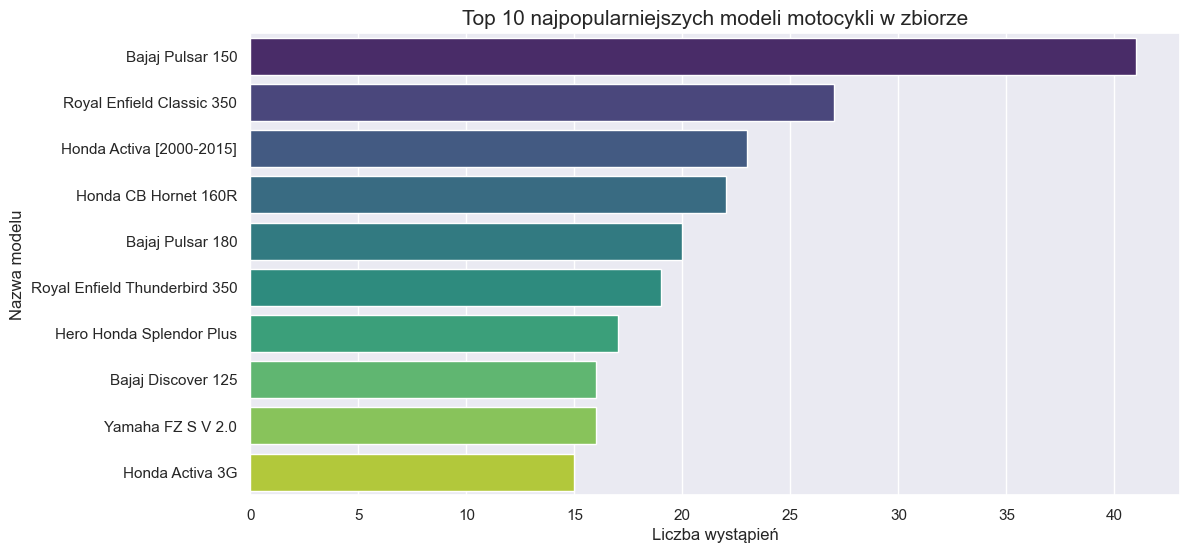

In [38]:
plt.figure(figsize=(12, 6))
top_models = df['name'].value_counts().head(10)
sns.barplot(x=top_models.values, y=top_models.index, palette='viridis')

plt.title('Top 10 najpopularniejszych modeli motocykli w zbiorze', fontsize=15)
plt.xlabel('Liczba wystąpień', fontsize=12)
plt.ylabel('Nazwa modelu', fontsize=12)
plt.show()

In [39]:
counts = df['name'].value_counts()
counts

name
Bajaj Pulsar 150                 41
Royal Enfield Classic 350        27
Honda Activa [2000-2015]         23
Honda CB Hornet 160R             22
Bajaj Pulsar 180                 20
                                 ..
Hero Honda CD100SS                1
Royal Enfield Thunderbird 500     1
BMW G310GS                        1
TVS Radeon                        1
Bajaj  ct 100                     1
Name: count, Length: 279, dtype: int64

In [40]:
# Liczba unikalnych motocykli liczebność = 1
counts[counts == 1].sum()

97

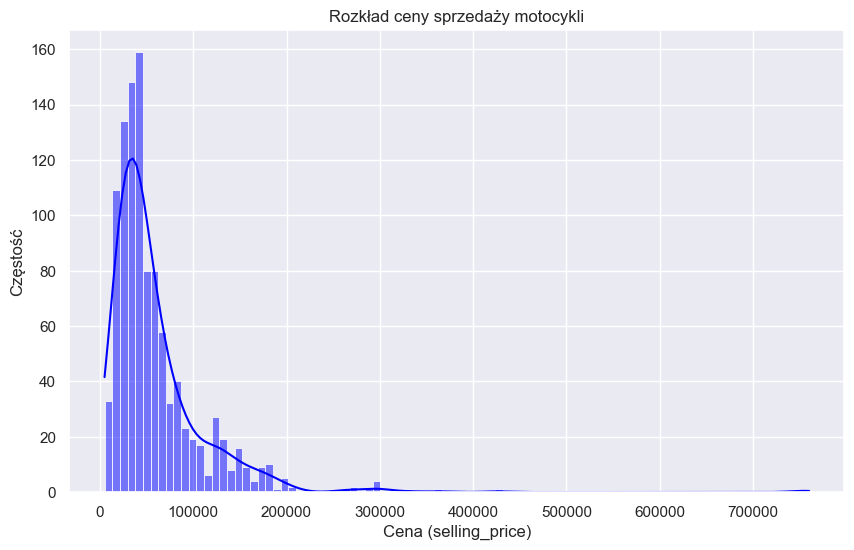

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(df['selling_price'], kde=True, color='blue')
plt.title('Rozkład ceny sprzedaży motocykli')
plt.xlabel('Cena (selling_price)')
plt.ylabel('Częstość')
plt.show()

In [42]:
print(f"Skośność ceny: {df['selling_price'].skew()}")

Skośność ceny: 4.993784115724287


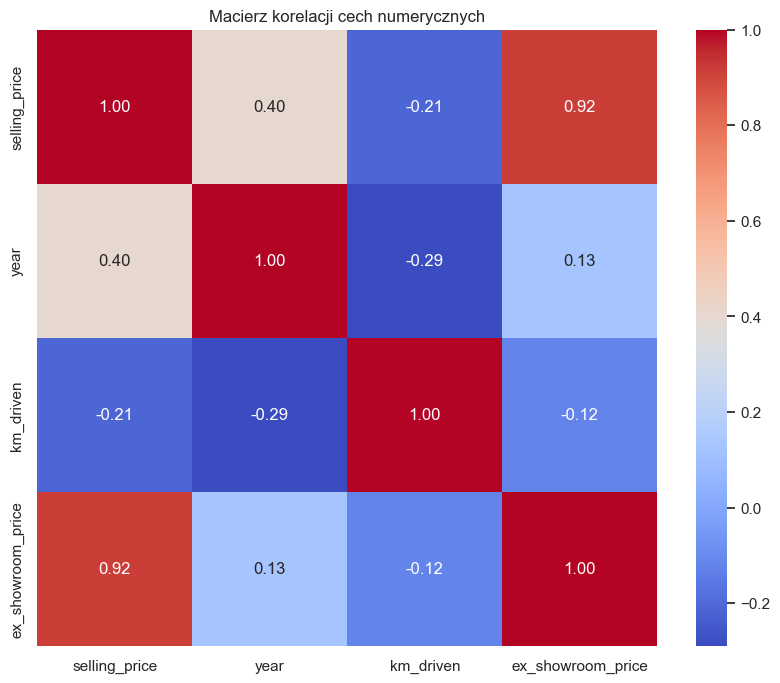

In [43]:
# Analiza korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz korelacji cech numerycznych')
plt.show()

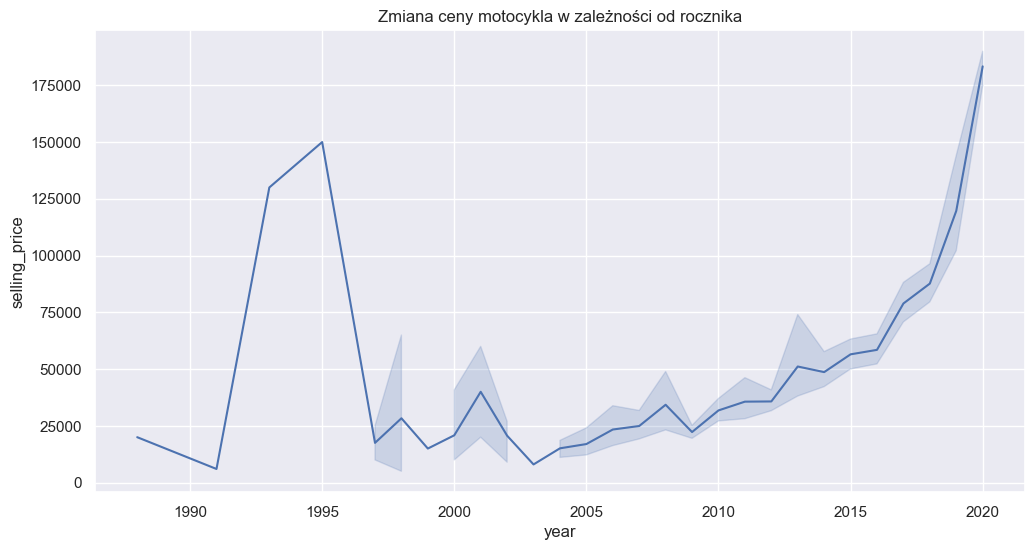

In [44]:
# Zależność ceny od roku

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year', y='selling_price')
plt.title('Zmiana ceny motocykla w zależności od rocznika')
plt.show()

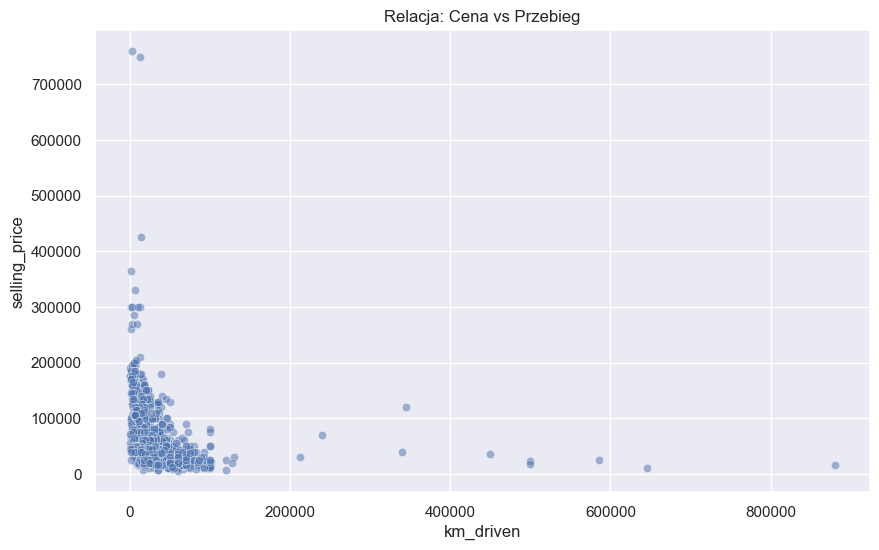

In [45]:
# Cena vs przebieg
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='km_driven', y='selling_price', alpha=0.5)
plt.title('Relacja: Cena vs Przebieg')
plt.show()

### Etap 2 - Przygotowanie danych

Największa korelacja jest między *ex_showroom_price* a *selling_price* = **0.92**, natomiast około 40% danych jest puste. Aby dane uzupełnić, zastąpione zostaną medianą ceny salonowej dla danej marki

Występuje kilka zmiennych odstających, zostanie wykorzystana transformacja logarytmiczna na zmiennej *selling_price* aby zbliżyć wartości odstające do rozkładu normalnego.

In [46]:
## wyciągnięcie marki
df['brand'] = df['name'].apply(lambda x: x.split(' ')[0])

In [47]:
# Imputacja ex_showroom_price na podstawie marki
brand_medians = df.groupby('brand')['ex_showroom_price'].transform('median')
df['ex_showroom_price'] = df['ex_showroom_price'].fillna(brand_medians)
df['ex_showroom_price'] = df['ex_showroom_price'].fillna(df['ex_showroom_price'].median()) # jeżeli z danej marki żadna nie miała ceny, wypełnienie medianą ogólną

df['selling_price_log'] = np.log1p(df['selling_price'])
df

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,brand,selling_price_log
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,160154.0,Royal,12.072547
1,Honda Dio,45000,2017,Individual,1st owner,5650,59183.0,Honda,10.714440
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0,Royal,11.918397
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0,Yamaha,11.082158
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,84000.0,Yamaha,9.903538
...,...,...,...,...,...,...,...,...,...
1056,Activa 3g,17000,2010,Individual,1st owner,500000,52000.0,Activa,9.741027
1057,Honda CB twister,16000,2012,Individual,1st owner,33000,51000.0,Honda,9.680406
1058,Bajaj Discover 125,15000,2013,Individual,2nd owner,35000,57000.0,Bajaj,9.615872
1059,Honda CB Shine,12000,2009,Individual,1st owner,53000,58000.0,Honda,9.392745


In [48]:
# Wybór cech do modelu
features = ['brand', 'year', 'seller_type', 'owner', 'km_driven', 'ex_showroom_price']
X = df[features]
y = df['selling_price_log']

categorical_features = ['brand', 'seller_type', 'owner']
numeric_features = ['year', 'km_driven', 'ex_showroom_price']

In [49]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.176, random_state=42)


X_train_prep = preprocessor.fit_transform(X_train).toarray()
X_val_prep = preprocessor.transform(X_val).toarray()
X_test_prep = preprocessor.transform(X_test).toarray()

print(f"Kształt danych po preprocessingu: {X_train_prep.shape}")

Kształt danych po preprocessingu: (742, 28)


### Etap 3 - opracowanie modeli


In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = X_train_prep.shape[1]

def build_model_1():
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_model_2():
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_model_3():
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model1 = build_model_1()
model2 = build_model_2()
model3 = build_model_3()


c:\Users\pawel\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,921 (7.50 KB)

 Trainable params: 1,921 (7.50 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,081 (55.00 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849 (58.00 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 384 (1.50 KB)

### Etap 4 - ocena opracowanych modeli


--- Trenowanie Modelu: Baseline ---


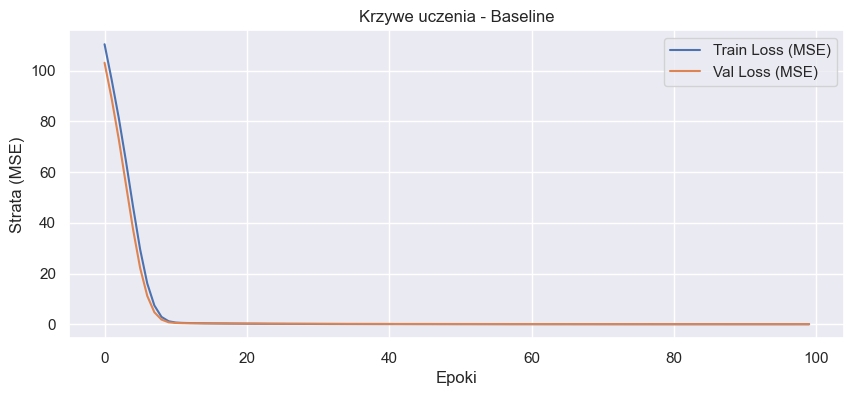

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

--- Trenowanie Modelu: Głęboka Sieć ---


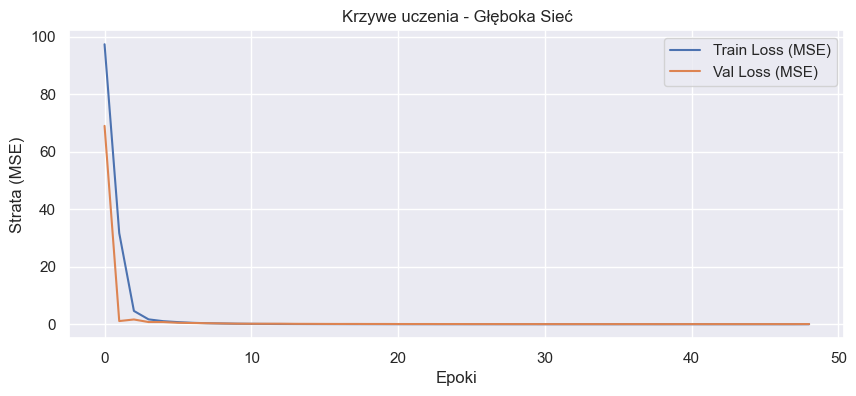

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

--- Trenowanie Modelu: Regularyzacja ---


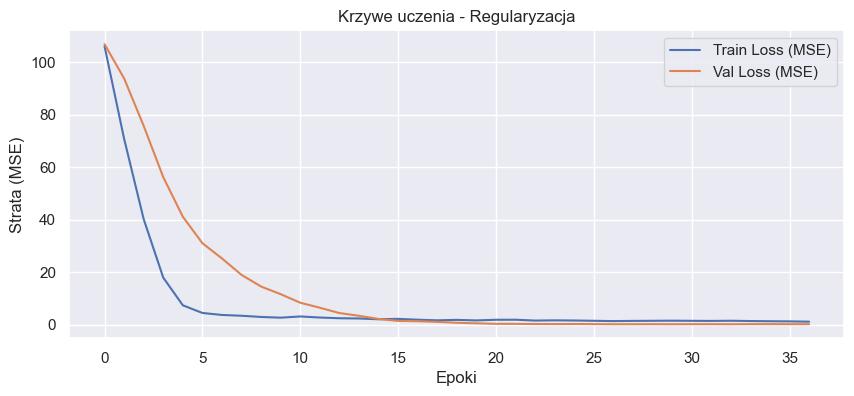

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001BE901BA520> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

--- Porównanie ilościowe modeli ---
           Model        R2           MAE          RMSE
0       Baseline  0.753739  13257.761406  22977.046430
1   Głęboka Sieć  0.772212  13066.626720  22098.468

In [55]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def train_and_evaluate(model, name, X_train, y_train, X_val, y_val):
    print(f"\n--- Trenowanie Modelu: {name} ---")
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )
    
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
    plt.title(f'Krzywe uczenia - {name}')
    plt.xlabel('Epoki')
    plt.ylabel('Strata (MSE)')
    plt.legend()
    plt.show()
    
    y_pred_log = model.predict(X_val)
    y_pred = np.expm1(y_pred_log).flatten()
    y_true = np.expm1(y_val).values
    
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return {"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse}, y_true, y_pred

results = []
preds = {}

models_list = [(model1, "Baseline"), (model2, "Głęboka Sieć"), (model3, "Regularyzacja")]

for m, name in models_list:
    res, y_true, y_pred = train_and_evaluate(m, name, X_train_prep, y_train, X_val_prep, y_val)
    results.append(res)
    preds[name] = y_pred

df_results = pd.DataFrame(results)
print("\n--- Porównanie ilościowe modeli ---")
print(df_results)